In [1]:
import json
import pandas as pd
import numpy as np
# from scipy.sparse import hstack
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import ast
from transformers import BertTokenizer, BertModel
import torch
import re
import os
from openai import OpenAI
from dotenv import load_dotenv
load_dotenv()
client = OpenAI() 

In [2]:
df= pd.read_csv('pull_requests_filtered_raw.csv')
df['comments'] = df['comments'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
df['comments'] = df['comments'].apply(lambda comments: [item for item in comments if item['type'] != 'issue'] if type(comments) is not float else comments)
df = df[df['comments'].apply(lambda x: isinstance(x, list) and len(x) > 0)]
df.head()

,PR Number,Title,Created At,Updated At,State,Files Changed,Total Comments,Decision Time,URL,Type of Change,LOC Changed,Closed Date,Integration,Author,comments
0,129755,Add HassRespond intent,2024-11-03 21:07:40+00:00,2024-11-04 00:15:25+00:00,merged,3,1,0,https://github.com/home-assistant/core/pull/12...,New feature (which adds functionality to an ex...,16,2024-11-03T22:38:52Z,intent,synesthesiam,"[{'type': 'review', 'diff_hunk': '@@ -420,6 +4..."
2,129675,Add DHCP discovery to lamarzocco,2024-11-02 11:36:32+00:00,2024-11-03 09:49:59+00:00,merged,5,7,0,https://github.com/home-assistant/core/pull/12...,New feature (which adds functionality to an ex...,113,2024-11-03T09:44:35Z,lamarzocco,zweckj,"[{'type': 'review', 'diff_hunk': '@@ -276,6 +2..."
3,129587,Add go2rtc debug_ui yaml key to enable go2rtc ui,2024-10-31 16:15:17+00:00,2024-11-02 19:42:37+00:00,merged,5,14,0,https://github.com/home-assistant/core/pull/12...,New feature (which adds functionality to an ex...,102,2024-10-31T19:56:53Z,go2rtc,edenhaus,"[{'type': 'review', 'diff_hunk': '@@ -72,9 +72..."
6,129466,Add boost switch to Smarty,2024-10-29 21:16:53+00:00,2024-11-02 15:01:47+00:00,merged,6,9,2,https://github.com/home-assistant/core/pull/12...,New feature (which adds functionality to an ex...,204,2024-11-01T10:08:56Z,smarty,marcodutto,"[{'type': 'review', 'diff_hunk': '@@ -0,0 +1,9..."
7,129439,Add sensors for energy trends for devices,2024-10-29 16:56:27+00:00,2024-10-30 20:02:11+00:00,merged,4,7,0,https://github.com/home-assistant/core/pull/12...,New feature (which adds functionality to an ex...,1204,2024-10-29T19:02:08Z,sense,kbickar,"[{'type': 'review', 'diff_hunk': '@@ -79,10 +7..."


In [ ]:
df.to_csv('prs_adjusted.csv', index=False)

In [3]:
def extract_text(comment_thread):
    conversation = []
    for comment in comment_thread:
        main_comment = comment.get('comment', {}).get('body', '')
        
        # Extract replies' bodies
        replies = comment.get('replies', [])
        reply_bodies = [reply.get('body', '') for reply in replies]
        
        # Combine the main comment and all replies into one string
        combined_text = "Thread:\n" + main_comment + "\nReplies:\n" + "\n".join(reply_bodies)
        conversation.append(combined_text)
    return conversation
# Apply the function to extract text from the comments column
df['processed_comments'] = df['comments'].apply(extract_text)
print(df['processed_comments'].iloc[1])

['Thread:\n```suggestion\r\n        "hostname": "gs[0-9]{6}",\r\n```\nReplies:\nThis are glob pattern not regexes, so the {6} doesn\'t work afaik. The [0-9] appears to be fine though. ', 'Thread:\n```suggestion\r\n        "hostname": "lm[0-9]{6}",\r\n```\nReplies:\n', 'Thread:\n```suggestion\r\n        "hostname": "mr[0-9]{6}",\r\n```\nReplies:\n', "Thread:\nMay be parametrize some hostnames to make sure all regex expressions are tested.\nReplies:\nI don't understand? I mean we are not evaluating the glob patterns here anyways, so we are just passing through the strings here. \nIt's not a bad idea though (added it)"]


In [4]:
def clean_comments(comments):
    try:


        combined_text = " ".join(comments)
        return combined_text
    except (ValueError, SyntaxError):
        # Return an empty string if there's an issue
        return ""

# Apply the function to the dataset
df['processed_comments'] = df['processed_comments'].apply(clean_comments)
df

,PR Number,Title,Created At,Updated At,State,Files Changed,Total Comments,Decision Time,URL,Type of Change,LOC Changed,Closed Date,Integration,Author,comments,processed_comments
0,129755,Add HassRespond intent,2024-11-03 21:07:40+00:00,2024-11-04 00:15:25+00:00,merged,3,1,0,https://github.com/home-assistant/core/pull/12...,New feature (which adds functionality to an ex...,16,2024-11-03T22:38:52Z,intent,synesthesiam,"[{'type': 'review', 'diff_hunk': '@@ -420,6 +4...",Thread:\nTests are missing.\nReplies:\nWaiting...
2,129675,Add DHCP discovery to lamarzocco,2024-11-02 11:36:32+00:00,2024-11-03 09:49:59+00:00,merged,5,7,0,https://github.com/home-assistant/core/pull/12...,New feature (which adds functionality to an ex...,113,2024-11-03T09:44:35Z,lamarzocco,zweckj,"[{'type': 'review', 'diff_hunk': '@@ -276,6 +2...","Thread:\n```suggestion\r\n ""hostname"": ..."
3,129587,Add go2rtc debug_ui yaml key to enable go2rtc ui,2024-10-31 16:15:17+00:00,2024-11-02 19:42:37+00:00,merged,5,14,0,https://github.com/home-assistant/core/pull/12...,New feature (which adds functionality to an ex...,102,2024-10-31T19:56:53Z,go2rtc,edenhaus,"[{'type': 'review', 'diff_hunk': '@@ -72,9 +72...",Thread:\nWhat's `EXCLUSE`? Do you mean `EXCLUD...
6,129466,Add boost switch to Smarty,2024-10-29 21:16:53+00:00,2024-11-02 15:01:47+00:00,merged,6,9,2,https://github.com/home-assistant/core/pull/12...,New feature (which adds functionality to an ex...,204,2024-11-01T10:08:56Z,smarty,marcodutto,"[{'type': 'review', 'diff_hunk': '@@ -0,0 +1,9...",Thread:\nThere is no use for `self._is_on` so ...
7,129439,Add sensors for energy trends for devices,2024-10-29 16:56:27+00:00,2024-10-30 20:02:11+00:00,merged,4,7,0,https://github.com/home-assistant/core/pull/12...,New feature (which adds functionality to an ex...,1204,2024-10-29T19:02:08Z,sense,kbickar,"[{'type': 'review', 'diff_hunk': '@@ -79,10 +7...",Thread:\nplease use .extend\nReplies:\n Thread...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9426,44760,Add function to Utility Meter to not reset on ...,2021-01-02 10:18:37+00:00,2021-01-05 20:13:45+00:00,closed,3,8,2,https://github.com/home-assistant/core/pull/44760,New feature (which adds functionality to an ex...,13,2021-01-04T19:37:21Z,utility_meter,gigatexel,"[{'type': 'review', 'diff_hunk': '@@ -260,7 +2...",Thread:\nThis is not necessary (it does nothin...
9427,44751,Add AI Speaker integration,2021-01-01 22:59:20+00:00,2021-01-30 12:08:22+00:00,closed,13,78,27,https://github.com/home-assistant/core/pull/44751,New integration (thank you!),405,2021-01-29T07:45:14Z,ai_speaker,asystentka-jolka,"[{'type': 'review', 'diff_hunk': '@@ -0,0 +1,4...",Thread:\nPlease extract the device specific in...
9428,44739,Add MQTT Number,2021-01-01 16:39:20+00:00,2022-04-07 18:11:19+00:00,merged,4,7,4,https://github.com/home-assistant/core/pull/44739,New feature (which adds functionality to an ex...,469,2021-01-06T07:27:47Z,mqtt,dgomes,"[{'type': 'review', 'diff_hunk': '@@ -145,6 +1...",Thread:\nThe MQTT integration doesn't support ...
9429,44733,Add option to extract single bit from a regist...,2021-01-01 15:00:46+00:00,2021-02-12 22:06:05+00:00,closed,3,5,41,https://github.com/home-assistant/core/pull/44733,New feature (which adds functionality to an ex...,73,2021-02-11T22:03:31Z,modbus,twproject,"[{'type': 'review', 'diff_hunk': '@@ -63,6 +63...",Thread:\nconstants belong in const.py\nReplies...


In [5]:

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BertModel.from_pretrained('bert-base-uncased')
model = model.to(device)

In [6]:
device

device(type='cuda')

In [6]:
def get_bert_embedding(text):
    # Tokenize the input and move inputs to the GPU
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    # Use the [CLS] token embedding as the sentence embedding
    embedding = outputs.last_hidden_state[:, 0, :].squeeze().cpu().numpy()  # Move output back to CPU
    return embedding

# Generate embeddings for each comment
embeddings = df['processed_comments'].apply(get_bert_embedding).tolist()

In [7]:
# Check for mismatched shapes
embedding_lengths = [len(e) if isinstance(e, (list, np.ndarray, torch.Tensor)) else 0 for e in embeddings]
print(embedding_lengths)  # List of lengths of each embedding

[768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768,

In [8]:
def remove_markers(text):
    # Remove "Thread" and "Reply" markers
    text = re.sub(r"Thread:\s*", "", text, flags=re.IGNORECASE)
    text = re.sub(r"Replies:\s*", "", text, flags=re.IGNORECASE)
    url_pattern = r"http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+"
    # Replace all matches with "[link]"
    re.sub(url_pattern, "[link]", text)

    return text.strip()

# Apply the function to remove markers
df['clustering_comments'] = df['processed_comments'].apply(remove_markers)
df['clustering_comments'][0]

'Tests are missing.\nWaiting on an intents bump before the test can be added.\nTests added in https://github.com/home-assistant/core/pull/129830'

In [9]:
embeddings_tensor = torch.tensor(embeddings, dtype=torch.float32).to(device)
scaler = StandardScaler()
normalized_embeddings = torch.tensor(scaler.fit_transform(embeddings_tensor.cpu().numpy())).to(device)


C:\Users\david\AppData\Local\Temp\ipykernel_91932\3393082744.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  embeddings_tensor = torch.tensor(embeddings, dtype=torch.float32).to(device)


In [10]:
def torch_kmeans(data, k, max_iters=300):
    # Randomly initialize cluster centroids
    centroids = data[torch.randperm(data.size(0))[:k]].clone()

    for _ in range(max_iters):
        # Assign each point to the nearest cluster centroid
        distances = torch.cdist(data, centroids)
        cluster_assignments = torch.argmin(distances, dim=1)

        # Update centroids
        new_centroids = torch.stack(
            [data[cluster_assignments == c].mean(dim=0) for c in range(k)]
        )
        
        # Check for convergence
        if torch.allclose(centroids, new_centroids, atol=1e-4):
            break

        centroids = new_centroids

    return cluster_assignments, centroids

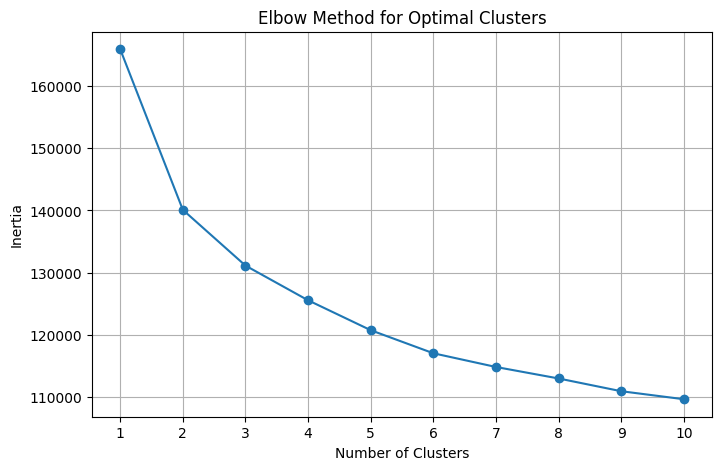

In [12]:
# Function to calculate inertia for different numbers of clusters
def elbow_method(embeddings, max_k=10):
    inertia = []
    for k in range(1, max_k + 1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(embeddings)
        inertia.append(kmeans.inertia_)
    return inertia

# Calculate inertia values
inertia_values = elbow_method(embeddings, max_k=10)

# Plot the elbow curve
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), inertia_values, marker='o')
plt.title('Elbow Method for Optimal Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.xticks(range(1, 11))
plt.grid()
plt.show()

In [22]:
num_clusters = 100
cluster_assignments, centroids = torch_kmeans(normalized_embeddings, num_clusters)


df['cluster'] = cluster_assignments.cpu().numpy()

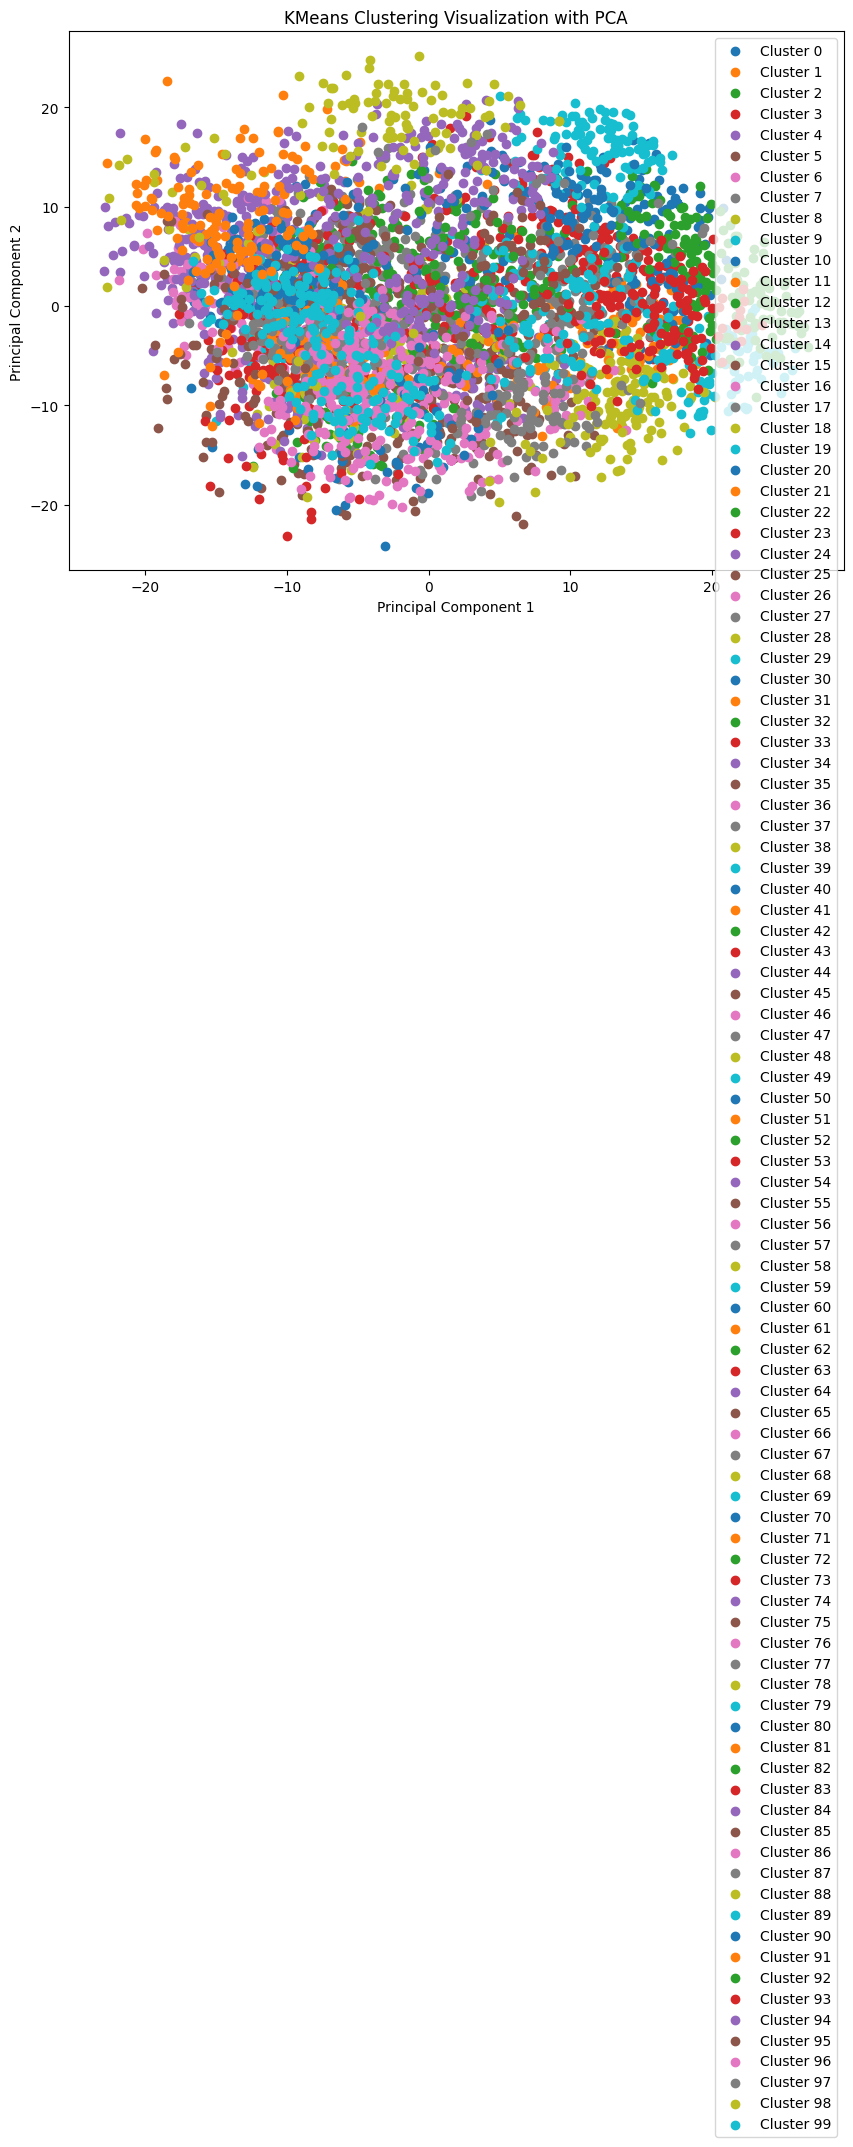

In [23]:
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(normalized_embeddings.cpu().numpy())

# Plot the clusters
plt.figure(figsize=(10, 7))
for cluster_id in range(num_clusters):
    cluster_points = reduced_embeddings[cluster_assignments.cpu().numpy() == cluster_id]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {cluster_id}")

plt.title("KMeans Clustering Visualization with PCA")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.show()

In [17]:
for cluster_id in range(num_clusters):  
    print(f"\nCluster {cluster_id}:")
    samples = df[df['cluster'] == cluster_id]['clustering_comments'].head(5)  # Adjust the column name as needed
    for sample in samples:
        print(f"- {sample}")



Cluster 0:
- Should this maybe just be called `_group_supports_execute_if_off` (instead of upper-casing)?

(I originally upper-cased it, as it was somewhat similar to the config values that are set when initializing the light classes and it's also done there (likely because it's somewhat of a constant?))
- If this is added here, it should be removed from `_entry_ext_dict` below
- Shouldn't this be set in `_async_setup_device_registry` like the other data?

Then it also works if the device has not entities
:man_facepalming:
- Move this check into the if statemenet when you assign `master_result`
- That would plaster every single entity with the add-on icon/logo. Is that wished for?
This also overrides device class icons (e.g., update on binary sensors)
:man_shrugging:

Cluster 1:
- Any reason it’s not just a dict ? We never read from the keys 
So we can remove the relevant media formats if a media player entity is removed. In the real world, this probably means the whole device ends up

In [18]:
def get_top_keywords(texts, n=10):
    vectorizer = CountVectorizer(stop_words='english', max_features=1000)
    X = vectorizer.fit_transform(texts)
    keywords = vectorizer.get_feature_names_out()
    keyword_counts = X.sum(axis=0).A1
    sorted_keywords = sorted(zip(keywords, keyword_counts), key=lambda x: x[1], reverse=True)
    return [keyword for keyword, _ in sorted_keywords[:n]]

# Get top keywords for each cluster
for cluster_id in range(num_clusters):
    cluster_texts = df[df['cluster'] == cluster_id]['clustering_comments']
    keywords = get_top_keywords(cluster_texts)
    print(f"\nCluster {cluster_id} Keywords: {keywords}")


Cluster 0 Keywords: ['device', 'set', 'somewhat', 'upper', '_async_setup_device_registry', '_entry_ext_dict', '_group_supports_execute_if_off', 'add', 'added', 'ahead']

Cluster 1 Keywords: ['don', 'entity', 'application', 'credentials', 'device', 'suggestion', 'coordinator', 'description', 'integration', 'just']

Cluster 2 Keywords: ['url', 'build', 'configuration_url', 'http', 'https', 'py', 'coordinator', 'device', 'import', 'scheme']

Cluster 3 Keywords: ['suggestion', 'defined', 'default', 'entry', 'icon', 'type', 'description', 'new', 'self', 'setting']

Cluster 4 Keywords: ['suggestion', 'https', 'assistant', 'home', 'com', 'core', 'github', 'use', 'device', 'pr']

Cluster 5 Keywords: ['integration', 'use', 'device', 'don', 'home', 'like', 'need', 'assistant', 'entity', 'service']

Cluster 6 Keywords: ['add', 'data', 'device', 'available', 'class', 'current', 'guess', 'hub', 'll', 'meter']

Cluster 7 Keywords: ['https', 'assistant', 'home', 'entity', 'core', 'io', 'com', 'devel

In [34]:
for cluster_id in range(num_clusters):
    cluster_texts = df[df['cluster'] == cluster_id]['clustering_comments']
    body = get_top_keywords(cluster_texts)
    
    chat_response = client.chat.completions.create(
    model="gpt-4o",
    temperature=0.2,
    messages=[
    {
        "role": "system",
        "content": (
            "You are a helpful assistant that can label clusters based on its top keywords."
        ),
    },
    {
        "role": "user",
        "content": (
            f"Here are some top keywords from some clusters, please label them: {body}"
            
        ),
    },
]


)

# Extract and clean the response
response_text = chat_response.choices[0].message.content

print(response_text)

AuthenticationError: Error code: 401 - {'error': {'message': 'Incorrect API key provided: sk-proj-********************************************************************************************************************************************************JKEA. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}

In [22]:
vectorizer = TfidfVectorizer(stop_words='english', max_features=500)
text_features = vectorizer.fit_transform(df['comment'])

In [6]:
df['comment_type_encoded'] = LabelEncoder().fit_transform(df['comment_type'].fillna(""))
df['is_code_owner_encoded'] = df['is_code_owner'].fillna(0).astype(int)
df['author_is_code_owner_encoded'] = df['author_is_code_owner'].fillna(0).astype(int)

KeyError: 'comment_type'

In [27]:
metadata_features = df[['comment_type_encoded', 'is_code_owner_encoded', 'author_is_code_owner_encoded']].values
combined_features = hstack([text_features, metadata_features])
df.head()

,comment_type,user,comment,date,commit_sha,author,commit_message,is_code_owner,author_is_code_owner,pull_request_url,comment_type_encoded,is_code_owner_encoded,author_is_code_owner_encoded
0,Issue,home-assistant[bot],\nHi @fender4645\n\nIt seems you haven't yet s...,2023-09-09T18:53:44Z,None,fender4645,None,False,False,https://github.com/home-assistant/core/pull/10...,1,0,0
1,Review,jbouwh,```suggestion\r\n _LOGGER.debug(\r\...,2023-09-09T21:13:37Z,None,fender4645,None,True,False,https://github.com/home-assistant/core/pull/10...,2,1,0
2,Review,jbouwh,```suggestion\r\n _LOGGER.debug(\r\...,2023-09-10T10:51:46Z,None,fender4645,None,True,False,https://github.com/home-assistant/core/pull/10...,2,1,0
3,NaN,NaN,,2023-09-09T17:56:29Z,dbeaa2d2798b709dc4a126e5d94b3657c6c9c43c,fender4645,Debug message if no detections found or\nno ou...,NaN,False,https://github.com/home-assistant/core/pull/10...,0,0,0
4,NaN,NaN,,2023-09-09T22:14:49Z,5862a57f58db7c18893723b646fd6bc729ca17d0,fender4645,fix formatting,NaN,False,https://github.com/home-assistant/core/pull/10...,0,0,0


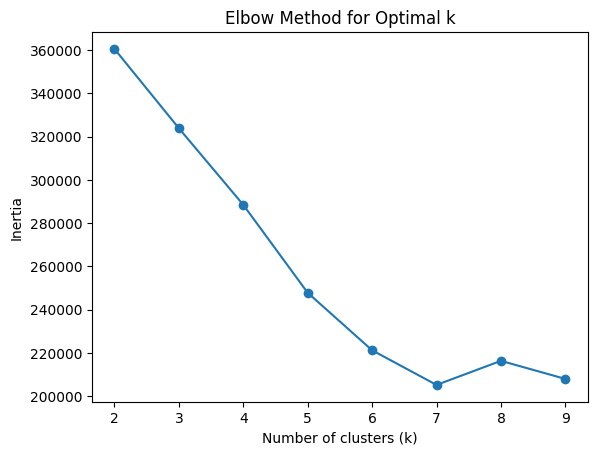

In [28]:
inertia = []
k_values = range(2, 10)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(combined_features)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.plot(k_values, inertia, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()


In [29]:
optimal_k = 6

kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df['cluster'] = kmeans.fit_predict(combined_features)

In [30]:
print(df['cluster'].value_counts())

cluster
0    132504
1     86737
4     54127
2     51069
5     33242
3     26933
Name: count, dtype: int64


In [31]:
for cluster in range(optimal_k):
    print(f"\nCluster {cluster}:")
    cluster_data = df[df['cluster'] == cluster]
    print(cluster_data['comment'].head(5))  # Example comments
    print(cluster_data[['comment_type', 'is_code_owner', 'author_is_code_owner']].describe())


Cluster 0:
10    
13    
14    
15    
30    
Name: comment, dtype: object
       comment_type is_code_owner author_is_code_owner
count             0             0               132504
unique            0             0                    1
top             NaN           NaN                 True
freq            NaN           NaN               132504

Cluster 1:
20    Could we maybe implement an `update_attr()` fu...
21                                            Not used?
22    Storing all the alerts with their data in the ...
23    Good point. Could we fire an event when a new ...
24    You could have another sensor with a timestamp...
Name: comment, dtype: object
       comment_type is_code_owner author_is_code_owner
count         86737         86737                86737
unique            1             2                    1
top          Review          True                 True
freq          86737         84153                86737

Cluster 2:
8                                        

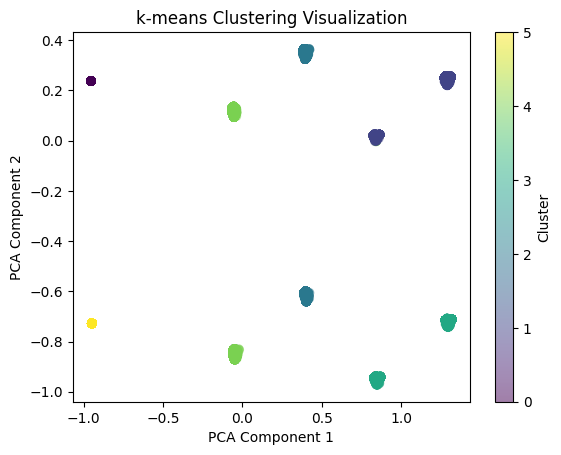

: 

In [32]:
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(combined_features.toarray())


plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=df['cluster'], cmap='viridis', alpha=0.5)
plt.title('k-means Clustering Visualization')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()